## General lab instructions
For every lab in this course, you must submit **two items**:

### **1. A Jupyter Notebook (`.ipynb`)**

Your notebook should:

* Contain **all code** needed to run your experiments
* Produce **all figures, tables, and outputs** used in your report
* Be **fully runnable from top to bottom** on a fresh kernel
* Include clear comments explaining your reasoning and workflow

The notebook will be evaluated both for **correctness** and **clarity**.

---

### **2. A Formal Lab Report (PDF or Markdown-to-PDF)**

Your report should:

* Be **self-contained** — a reader should understand everything without opening your notebook
* Present results in a **clean, professional style**
* Include:

  * All asked-for figures with captions
  * All asked-for tables summarizing performance
  * Answers to all discussion questions 


---

### 🔍 Academic Expectations

You must be prepared to:

* **Explain your code**
* **Walk through your debugging steps**
* **Justify your modeling decisions**

Some future quizzes may include questions **directly about the code you were supposed to write**, so make sure you understand every part of your implementation.


# Lab 1: Classical and Neural Models for Multiclass Classification

In this lab, you will explore a progression of classification models—starting from simple, classical methods and building up to a **multilayer perceptron (MLP)** capable of solving nonlinear tasks. You will begin with an easy, linearly separable dataset and then move on to a much harder nonlinear dataset (spirals) to understand where classical methods succeed or fail.

You will train and compare the following models:

* **Multiclass Logistic Regression**
* **Decision Tree Classifier**
* **K-Nearest Neighbors (KNN)**
* **Multilayer Perceptron (MLP)** with custom components

By visualizing their decision boundaries, you will see how each model behaves and why depth, width, and nonlinear activation functions matter.

---

## What You Will Implement

### Classical Models (using scikit-learn)

* Train and evaluate:

  * Logistic Regression
  * Decision Tree
  * KNN
* Visualize the decision boundaries for each model on:

  * **Separable blobs dataset**
  * **Spiral dataset**

This establishes a baseline for what classical models can and cannot do.

### Neural Network (using PyTorch)

You will then build and train an MLP from lower-level components.

You will:

* Use a provided implementation of the **Linear layer forward pass**.
* Implement your own **ReLU activation**, including a custom backward rule.
* Assemble these components into a multi-layer network.
* Train the MLP on both datasets and compare performance.

In [1]:
# Import PyTorch core package for tensor ops and autograd.
import torch
# Import PyTorch neural-network module for layers/losses.
import torch.nn as nn
# Import matplotlib plotting interface.
import matplotlib.pyplot as plt
# Import math utilities (pi, sin, cos, sqrt, etc.).
import math
# Import multiclass logistic regression from scikit-learn.
from sklearn.linear_model import LogisticRegression
# Import decision tree classifier from scikit-learn.
from sklearn.tree import DecisionTreeClassifier
# Import k-nearest-neighbors classifier from scikit-learn.
from sklearn.neighbors import KNeighborsClassifier

# Import NumPy for arrays and mesh-grid utilities.
import numpy as np
# Import matplotlib again (kept for notebook compatibility/readability).
import matplotlib.pyplot as plt


## Visualizing Three Types of Separable Datasets

In this section, we compare **three multiclass datasets** that are all separable, but in fundamentally different ways. Each dataset highlights a different level of geometric complexity and poses different challenges for classical machine learning models.

### **1. Linearly Separable Blobs**

A simple dataset where each class forms a compact, roughly spherical cluster.
The classes can be separated using straight lines (linear decision boundaries).
Models like **logistic regression**, **decision trees**, and **KNN** all perform very well here.

---

### **2. Overlapping Ellipsoids**

A moderately challenging dataset where each class forms an **ellipse** with its own size, orientation, and eccentricity.
The ellipsoids **overlap**, so the dataset is still separable but not perfectly clean.
Linear models begin to struggle, while models that capture more structure—like **KNN**, **decision trees**, and small **MLPs**—perform better.

---

### **3. Spiral Dataset**

A highly nonlinear dataset in which each class forms a spiral arm.
These classes are separable **only through very complex, curved boundaries**.
Linear models fail completely, and even classical nonlinear methods (trees, KNN) perform inconsistently.
Only models capable of deep nonlinear transformations—such as multilayer perceptrons (MLPs)—can learn an effective decision boundary.


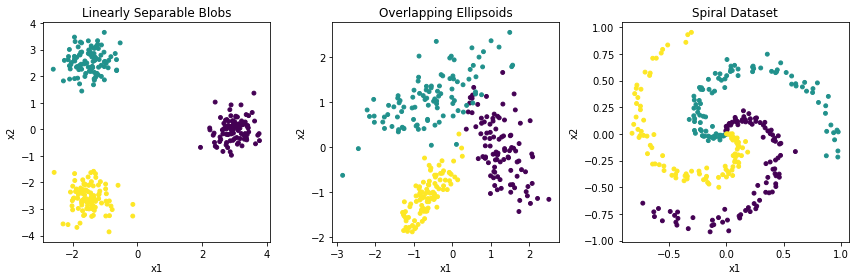

In [2]:
# Import torch for tensor creation and random sampling.
import torch
# Import math for trigonometric functions and pi.
import math
# Import plotting tools for dataset visualization.
import matplotlib.pyplot as plt

# Define a generator for linearly separable Gaussian blobs.
def make_separable_blobs(n_points_per_class=100, n_classes=3, spread=0.5, seed=0):
    # Fix random seed so results are reproducible.
    torch.manual_seed(seed)
    # Allocate feature matrix with shape (total_points, 2).
    X = torch.zeros(n_points_per_class * n_classes, 2)
    # Allocate label vector with integer class labels.
    y = torch.zeros(n_points_per_class * n_classes, dtype=torch.long)

    # Create equally spaced angles around the circle.
    angles = torch.linspace(0, 2 * math.pi, n_classes + 1)[:-1]
    # Convert angles into 2D centers and scale radius outward.
    centers = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1) * 3.0

    # Loop over classes and sample one Gaussian cluster per class.
    for j in range(n_classes):
        # Compute index slice for the j-th class block.
        ix = range(j * n_points_per_class, (j + 1) * n_points_per_class)
        # Read the class center from precomputed centers.
        center = centers[j]
        # Sample noisy points around this center.
        X[ix] = center + torch.randn(n_points_per_class, 2) * spread
        # Assign the class id j to all sampled points.
        y[ix] = j

    # Return features and labels.
    return X, y

# Define a generator for 3-class spiral data (nonlinear separation).
def make_spiral(n_points_per_class=100, n_classes=3, noise=0.2, seed=1):
    # Fix random seed for reproducibility.
    torch.manual_seed(seed)
    # Allocate output feature matrix.
    X = torch.zeros(n_points_per_class * n_classes, 2)
    # Allocate output label vector.
    y = torch.zeros(n_points_per_class * n_classes, dtype=torch.long)

    # Build one spiral arm per class.
    for j in range(n_classes):
        # Index range occupied by this class.
        ix = range(n_points_per_class * j, n_points_per_class * (j + 1))
        # Radius grows from center outward.
        r = torch.linspace(0.0, 1, n_points_per_class)
        # Angle sweeps per class with extra random jitter.
        t = torch.linspace(j * 4, (j + 1) * 4, n_points_per_class) + torch.randn(n_points_per_class) * noise
        # Convert polar-like coordinates to Cartesian coordinates.
        X[ix] = torch.stack((r * torch.sin(t), r * torch.cos(t)), dim=1)
        # Write class labels.
        y[ix] = j

    # Return generated spiral points.
    return X, y

# Define a generator for overlapping ellipsoidal clusters.
def make_ellipsoids(n_points_per_class=100, n_classes=3, scale=1.0, seed=2):
    # Set seed for reproducible random covariance/rotation.
    torch.manual_seed(seed)
    # Allocate feature matrix.
    X = torch.zeros(n_points_per_class * n_classes, 2)
    # Allocate label vector.
    y = torch.zeros(n_points_per_class * n_classes, dtype=torch.long)

    # Place centers close together to force overlap.
    angles = torch.linspace(0, 2 * math.pi, n_classes + 1)[:-1]
    # Convert center angles to Cartesian coordinates and scale radius.
    centers = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1) * 1.2

    # Generate one ellipsoid per class.
    for j in range(n_classes):
        # Compute destination indices for this class.
        ix = range(j * n_points_per_class, (j + 1) * n_points_per_class)
        # Select center of this class cluster.
        center = centers[j]
        # Random major/minor eigenvalues control ellipse axis lengths.
        eigvals = torch.tensor([
            torch.rand(1).item() * 0.8 + 0.2,
            torch.rand(1).item() * 0.2 + 0.05
        ]) * scale
        # Random rotation angle for ellipse orientation.
        theta = torch.rand(1).item() * math.pi
        # Build 2D rotation matrix from theta.
        R = torch.tensor([[math.cos(theta), -math.sin(theta)],
                          [math.sin(theta),  math.cos(theta)]])
        # Construct covariance matrix with rotated axes.
        cov = R @ torch.diag(eigvals) @ R.t()
        # Sample multivariate normal points for this class.
        pts = torch.distributions.MultivariateNormal(center, cov).sample((n_points_per_class,))
        # Store sampled points.
        X[ix] = pts
        # Store labels.
        y[ix] = j

    # Return ellipsoid dataset.
    return X, y

# Generate linearly separable blobs.
X_sep, y_sep = make_separable_blobs(n_classes=3, spread=0.4)
# Generate overlapping ellipsoids.
X_ellip, y_ellip = make_ellipsoids(n_classes=3, scale=1.0)
# Generate spirals.
X_spiral, y_spiral = make_spiral()

# Create wide figure with three panels.
plt.figure(figsize=(12, 4))
# Activate first subplot (blobs).
plt.subplot(1, 3, 1)
# Scatter-plot blobs colored by class label.
plt.scatter(X_sep[:, 0], X_sep[:, 1], c=y_sep, cmap="viridis", s=15)
# Set title of first panel.
plt.title("Linearly Separable Blobs")
# Label horizontal axis.
plt.xlabel("x1")
# Label vertical axis.
plt.ylabel("x2")

# Activate second subplot (ellipsoids).
plt.subplot(1, 3, 2)
# Scatter-plot ellipsoids colored by class.
plt.scatter(X_ellip[:, 0], X_ellip[:, 1], c=y_ellip, cmap="viridis", s=15)
# Set title of second panel.
plt.title("Overlapping Ellipsoids")
# Label x-axis.
plt.xlabel("x1")
# Label y-axis.
plt.ylabel("x2")

# Activate third subplot (spiral).
plt.subplot(1, 3, 3)
# Scatter-plot spiral points.
plt.scatter(X_spiral[:, 0], X_spiral[:, 1], c=y_spiral, cmap="viridis", s=15)
# Set title of third panel.
plt.title("Spiral Dataset")
# Label x-axis.
plt.xlabel("x1")
# Label y-axis.
plt.ylabel("x2")

# Adjust subplot spacing to avoid overlaps.
plt.tight_layout()
# Render the figure.
plt.show()


## Part 1: Classical Models for Multiclass Classification

In the next set of exercises, you will explore three classical machine learning models:

* **Multiclass Logistic Regression**
* **K-Nearest Neighbors (KNN)**
* **Decision Tree Classifier**

The code to train and visualize these models is **provided for you**.
Your primary responsibility here is **not** to write new code, but to perform **careful analysis**, **interpretation**, and **comparison**.

We will evaluate these models on **three datasets**, each representing a different level of geometric complexity:

1. **Linearly Separable Blobs** — ideal for linear decision boundaries
2. **Overlapping Ellipsoids** — moderately difficult, partially overlapping, nonlinear structure
3. **Spiral Dataset** — strongly nonlinear and difficult for classical methods

Together, these datasets highlight differences in **model capacity**, **decision boundary geometry**, **local vs global behavior**, and **computational tradeoffs**.

---

## Your Tasks

### A. **Comment the Code Thoroughly**

For each block of provided code (model training + decision boundary plotting):

* Describe what each line does
* Explain why the code supports multiclass classification
* Identify how the decision function is used to generate boundaries
* Comment on any parameters or design choices that affect model behavior

Your comments should reflect genuine understanding, not just translation.

---

### B. **Explain and Compare Model Behavior**

For **each model × dataset combination** (3 models × 3 datasets):

* **Describe the shape of the decision boundary**
  (straight, smooth, jagged, piecewise constant, highly local, etc.)
* **Explain why the model succeeds, fails, or partially succeeds**
  (linearity, locality, capacity, overfitting, geometry of the dataset)
* **Discuss how model assumptions shape the outcome**
  Example: logistic regression assumes linear separability; KNN assumes local similarity; decision trees partition space axis-aligned.

Pay particular attention to:

* **linear vs nonlinear capacity**
* **local vs global decision-making**
* **smooth vs irregular decision regions**

---

### C. **Analyze Computational Time**

For each model:

* Measure **training time**
* Measure **prediction time** (important for KNN)

Then:

* Compare the computational profiles of the three models
* Explain which models scale poorly with data size and why
* Discuss which models are “fast but inflexible” (e.g., logistic regression) vs “slow but expressive” (e.g., KNN)

You may use timing code or a stopwatch, but record your results clearly.

---

### D. **Discussion & Reflection**

Write a short paragraph that addresses:

* Why logistic regression fails on nonlinear datasets (ellipsoids and spirals)
* Why KNN sometimes performs surprisingly well despite its simplicity
* Why decision trees can overfit dramatically and produce jagged boundaries
* When classical models break down—and what this implies for neural networks

Your explanations should synthesize both **visual evidence** and **model properties**.

---

## Deliverables Summary

Submit the following for the classical models section:

1. **Commented code** for:

   * Logistic Regression block
   * KNN block
   * Decision Tree block
   * Decision boundary plotting code
2. **Plots** for all **9 combinations** (3 models × 3 datasets), each with a caption briefly explaining model behavior
3. **A table of misclassification rates** covering all models × datasets
4. **A table (or paragraph) summarizing timing measurements** (training + prediction)
5. **A short reflection paragraph** addressing the discussion questions above



In [3]:
# Define helper to visualize model-predicted class regions in 2D.
def plot_decision_boundary(X, y, model, title="", ax=None):
    # Set grid resolution (smaller step -> smoother boundary, more compute).
    h = 0.01
    # Compute left/right x-limits from data with extra margin.
    x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    # Compute bottom/top y-limits from data with extra margin.
    y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    # Build rectangular coordinate grid over plotting area.
    xx, yy = np.meshgrid(
        # Generate x coordinates at step h.
        np.arange(x_min, x_max, h),
        # Generate y coordinates at step h.
        np.arange(y_min, y_max, h)
    )
    # Flatten grid into N x 2 coordinate list for batch prediction.
    grid = np.c_[xx.ravel(), yy.ravel()]
    # Predict class on each grid point and reshape back to grid shape.
    Z = model.predict(grid).reshape(xx.shape)
    # If no axis provided, use current matplotlib axis.
    if ax is None:
        ax = plt.gca()
    # Draw filled contour for predicted regions.
    ax.contourf(xx, yy, Z, cmap="Spectral", alpha=0.4)
    # Overlay true data points with class colors.
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap="Spectral", edgecolor="k", s=20)
    # Apply title to this subplot.
    ax.set_title(title)


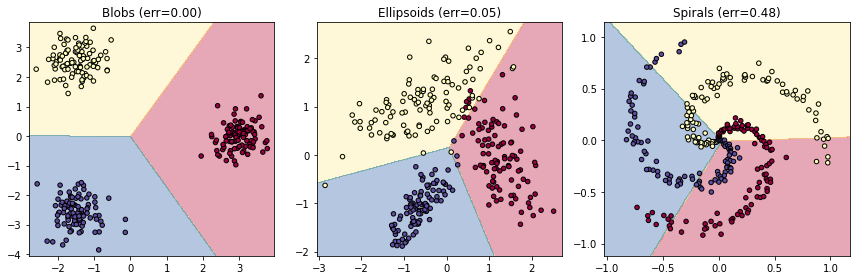

In [4]:
# Convert torch tensors to NumPy arrays for scikit-learn compatibility.
Xs, ys = X_sep.numpy(), y_sep.numpy()
# Convert ellipsoid tensors to NumPy arrays.
Xell, yell = X_ellip.numpy(), y_ellip.numpy()
# Convert spiral tensors to NumPy arrays.
Xsp, ysp = X_spiral.numpy(), y_spiral.numpy()

# Create multinomial logistic regression classifier.
logreg = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500)
# Create a 1x3 subplot canvas.
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Fit logistic regression on blob dataset.
logreg.fit(Xs, ys)
# Predict blob labels.
pred = logreg.predict(Xs)
# Compute blob training error.
err = (pred != ys).mean()
# Plot blob decision boundary and points.
plot_decision_boundary(Xs, ys, logreg, title=f"Blobs (err={err:.2f})", ax=axes[0])

# Fit logistic regression on ellipsoid dataset.
logreg.fit(Xell, yell)
# Predict ellipsoid labels.
pred = logreg.predict(Xell)
# Compute ellipsoid training error.
err = (pred != yell).mean()
# Plot ellipsoid decision boundary and points.
plot_decision_boundary(Xell, yell, logreg, title=f"Ellipsoids (err={err:.2f})", ax=axes[1])

# Fit logistic regression on spiral dataset.
logreg.fit(Xsp, ysp)
# Predict spiral labels.
pred = logreg.predict(Xsp)
# Compute spiral training error.
err = (pred != ysp).mean()
# Plot spiral decision boundary and points.
plot_decision_boundary(Xsp, ysp, logreg, title=f"Spirals (err={err:.2f})", ax=axes[2])

# Adjust subplot spacing.
plt.tight_layout()
# Render figure.
plt.show()


In [5]:
# Initialize KNN classifier with 5 neighbors.
knn = KNeighborsClassifier(n_neighbors=5)
# Create 1x3 subplot layout.
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Train KNN on blob data.
knn.fit(Xs, ys)
# Predict blob labels.
pred = knn.predict(Xs)
# Compute blob training error.
err = (pred != ys).mean()
# Plot blob boundary.
plot_decision_boundary(Xs, ys, knn, title=f"KNN (Blobs) err={err:.2f}", ax=axes[0])

# Train KNN on ellipsoid data.
knn.fit(Xell, yell)
# Predict ellipsoid labels.
pred = knn.predict(Xell)
# Compute ellipsoid training error.
err = (pred != yell).mean()
# Plot ellipsoid boundary.
plot_decision_boundary(Xell, yell, knn, title=f"KNN (Ellipsoids) err={err:.2f}", ax=axes[1])

# Train KNN on spiral data.
knn.fit(Xsp, ysp)
# Predict spiral labels.
pred = knn.predict(Xsp)
# Compute spiral training error.
err = (pred != ysp).mean()
# Plot spiral boundary.
plot_decision_boundary(Xsp, ysp, knn, title=f"KNN (Spirals) err={err:.2f}", ax=axes[2])

# Adjust subplot spacing.
plt.tight_layout()
# Display the figure.
plt.show()


In [6]:
# Initialize decision tree with fixed max depth and seed.
tree = DecisionTreeClassifier(max_depth=5, random_state=0)
# Create 1x3 subplot layout.
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Train tree on blob data.
tree.fit(Xs, ys)
# Predict blob labels.
pred = tree.predict(Xs)
# Compute blob training error.
err = (pred != ys).mean()
# Plot blob tree boundary.
plot_decision_boundary(Xs, ys, tree, title=f"Tree (Blobs) err={err:.2f}", ax=axes[0])

# Train tree on ellipsoid data.
tree.fit(Xell, yell)
# Predict ellipsoid labels.
pred = tree.predict(Xell)
# Compute ellipsoid training error.
err = (pred != yell).mean()
# Plot ellipsoid tree boundary.
plot_decision_boundary(Xell, yell, tree, title=f"Tree (Ellipsoids) err={err:.2f}", ax=axes[1])

# Train tree on spiral data.
tree.fit(Xsp, ysp)
# Predict spiral labels.
pred = tree.predict(Xsp)
# Compute spiral training error.
err = (pred != ysp).mean()
# Plot spiral tree boundary.
plot_decision_boundary(Xsp, ysp, tree, title=f"Tree (Spirals) err={err:.2f}", ax=axes[2])

# Adjust spacing for readability.
plt.tight_layout()
# Show the figure.
plt.show()


## Part 2: Exploring Multilayer Perceptrons (MLPs)

In this section, you will train **multilayer perceptrons** on the same three datasets from Part 1:

1. **Linearly Separable Blobs**
2. **Overlapping Ellipsoids**
3. **Spiral Dataset**

Unlike the classical models, MLPs can learn complex nonlinear transformations.
Your goal here is to explore **how architectural choices** and **training choices** affect an MLP’s ability to learn decision boundaries.

All PyTorch MLP code is **provided for you**.
You do **not** need to implement any layers yet.

---

## Your Tasks

### A. Train MLPs With Multiple Architectures

You will train several MLP architectures. Suggested examples:

* Small: **[2 → 16 → 3]**
* Medium: **[2 → 32 → 32 → 3]**
* Wide: **[2 → 128 → 128 → 3]**
* Deep: **[2 → 64 → 64 → 64 → 3]**
* Very deep (optional): **5–7 layers**

You *may* experiment with more architectures, but only include **properly trained models** in your final tables. Include at least 5 and no more than 10.

For each architecture:

* Train the model on all three datasets
* Visualize the decision boundary
* Record the classification error

---

### B. Create a Results Table

Construct a table where:

* **Rows = MLP architectures you trained**
* **Columns = the three datasets**
* **Cells = your misclassification rates (or accuracies)**

Example layout:

| Architecture | Blobs Error | Ellipsoids Error | Spirals Error |
| ------------ | ----------- | ---------------- | ------------- |
| 2–16–3       |             |                  |               |
| 2–32–32–3    |             |                  |               |
| 2–64–64–3    |             |                  |               |
| 2–64–64–64–3 |             |                  |               |

Be consistent in how you measure error.

---

### C. Training Choices (Discussion Only)

Although you should only **showcase well-trained models**, you must **analyze** how training choices influence outcomes.

For each architecture, write short notes on:

* Learning rate choices (too large vs too small)
* Optimization algorithm (SGD vs Adam—no need to try both unless curious)
* Number of epochs required for convergence
* Sensitivity to initialization
* Whether deeper or wider networks trained faster or slower

You do **not** need to submit poorly trained models—just discuss what went wrong when you experimented.

---

### D. Visualizations

For each architecture × dataset combination:

* Save a decision boundary plot (like in Part 1)
* Include a brief caption (1–2 sentences) interpreting the result

---



### E. Reflection Questions

Answer these directly in your report:

1. **Why does adding depth help on the spiral dataset but not on the blobs dataset?**

2. **Why might very wide networks succeed even when they have only one or two hidden layers?**

3. **Which dataset was the hardest for the MLP, and what properties of the dataset made it difficult?**

4. **How did depth and width affect training, in terms of sensitivity to initialization and training time?**

5. **Did deeper networks always perform better? Why or why not?**

---

## Deliverables for Part 2

1. **Table of results** (architectures × datasets)
2. **Decision boundary plots** for all trained MLPs
3. **Short written analysis** of training choices
4. **Reflection questions** answered thoughtfully


In [7]:
# Define a standard PyTorch MLP for multiclass classification.
class MLP(nn.Module):
    # Initialize architecture hyperparameters and layers.
    def __init__(self, input_dim=2, hidden=64, n_classes=3):
        # Initialize nn.Module internals.
        super().__init__()
        # First affine layer: input -> hidden.
        self.fc1 = nn.Linear(input_dim, hidden)
        # Second affine layer: hidden -> hidden.
        self.fc2 = nn.Linear(hidden, hidden)
        # Output affine layer: hidden -> class logits.
        self.fc3 = nn.Linear(hidden, n_classes)
        # Nonlinear activation used between linear layers.
        self.act = nn.ReLU()

    # Define forward pass from inputs to logits.
    def forward(self, x):
        # Compute first pre-activation.
        z1 = self.fc1(x)
        # Apply nonlinearity.
        a1 = self.act(z1)
        # Compute second pre-activation.
        z2 = self.fc2(a1)
        # Apply nonlinearity again.
        a2 = self.act(z2)
        # Compute final class logits.
        logits = self.fc3(a2)
        # Return logits for loss computation.
        return logits

    # Define convenience method for NumPy-friendly predictions.
    def predict(self, X):
        # Convert NumPy input to float32 tensor.
        if isinstance(X, np.ndarray):
            X = torch.tensor(X, dtype=torch.float32)
        # Put module in eval mode.
        self.eval()
        # Disable gradient tracking for inference.
        with torch.no_grad():
            # Run forward pass to get logits.
            logits = self.forward(X)
            # Convert logits to predicted class index.
            preds = logits.argmax(dim=1)
        # Return predictions as NumPy array.
        return preds.cpu().numpy()


In [8]:
# Define generic training loop for any compatible model.
def train_model(X, y, model, lr=1e-2, epochs=500):
    # Set model to training mode.
    model.train()
    # Create Adam optimizer over model parameters.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Use cross-entropy loss for multiclass logits.
    criterion = nn.CrossEntropyLoss()

    # Iterate optimization steps.
    for epoch in range(epochs):
        # Forward pass: compute logits.
        logits = model(X)
        # Compute classification loss.
        loss = criterion(logits, y)
        # Zero previous gradients.
        optimizer.zero_grad()
        # Backpropagate through computation graph.
        loss.backward()
        # Update parameters.
        optimizer.step()
        # Log periodic progress.
        if epoch % 100 == 0:
            print(f"epoch {epoch:4d} | loss = {loss.item():.4f}")

    # Return trained model.
    return model


## Part 3: Building Your Own Activation Function (ReLU)

In this section, you will take your first step toward implementing neural networks **from scratch**.
Up to this point, you used PyTorch’s built-in layers and activations. Now, you will:

1. Implement your own ReLU activation
2. Use the provided `Linear` block as a reference
3. Integrate your custom ReLU into an MLP
4. Verify that your MLP trains correctly on the three datasets

This helps you understand *exactly* how forward propagation works and why nonlinearities are essential for learning complex boundaries.

---

### What You Will Build

You are given a fully working `Linear` block:

```python
class Linear(nn.Module):
    class LinearFunction(torch.autograd.Function):
        ...
```

Your job is to create a similar block for ReLU.

You will implement:

* a **forward pass**:
  ( \text{ReLU}(x) = \max(x, 0) )

* and a **backward pass** using `torch.autograd.Function`:
  the derivative is ( 1 ) where ( x > 0 ) and ( 0 ) where ( x \le 0 )

Once finished, replace PyTorch’s built-in `nn.ReLU()` with **your own custom ReLU class** and train an MLP successfully.

---

## Your Tasks

### A. Implement a Custom ReLU

Create a class:

```python
class ReLU(nn.Module):
    class ReLUFunction(torch.autograd.Function):
        @staticmethod
        def forward(ctx, x):
            ...
        @staticmethod
        def backward(ctx, grad_out):
            ...
```

* Follow the structure of `LinearFunction`
* Save any tensors needed for backward computation
* Return correct gradients

---

### B. Use Your ReLU in an MLP

Modify your earlier MLP so that:

```python
self.act = ReLU()
```

Instead of:

```python
self.act = nn.ReLU()
```

Train your MLP on:

* Blobs
* Ellipsoids
* Spirals

Confirm the model still learns.
(If not, debug carefully: your backward pass is the most common source of mistakes.)

---

### C. Draw a Forward-Pass Diagram

Draw a clean figure showing:

```
Input (batch_size × 2)
   → Linear1 (2 × hidden)
   → ReLU
   → Linear2 (hidden × hidden)
   → ReLU
   → Linear3 (hidden × 3)
   → logits (batch_size × 3)
```

Your diagram must:

* Show each tensor shape
* Label each transformation
* Make clear how data flows left → right

You may draw it on paper and take a photo, or draw digitally.

---

## Reflection Questions

Include short answers (2–4 sentences each):

1. **Why does an MLP without nonlinearities collapse into a linear model?**
2. **What would happen if ReLU backward incorrectly returned gradients for negative inputs?**
3. **Why is it useful to wrap the forward/backward logic inside `torch.autograd.Function` instead of writing manual gradient loops?**



In [10]:
# Define custom ReLU module using manual autograd function.
class ReLU(nn.Module):
    # Define low-level forward/backward ops for ReLU.
    class ReLUFunction(torch.autograd.Function):
        # Forward pass: clamp negatives to zero.
        @staticmethod
        def forward(ctx, x):
            # Save input tensor for backward mask computation.
            ctx.save_for_backward(x)
            # Return elementwise max(x, 0).
            return torch.clamp(x, min=0)

        # Backward pass: gradient passes only where x > 0.
        @staticmethod
        def backward(ctx, grad_output):
            # Recover saved forward input.
            (x,) = ctx.saved_tensors
            # Clone incoming gradient tensor.
            grad_x = grad_output.clone()
            # Zero gradient where forward input was non-positive.
            grad_x[x <= 0] = 0
            # Return gradient w.r.t. x.
            return grad_x

    # Wrap custom autograd function in nn.Module interface.
    def forward(self, x):
        # Apply custom ReLU function.
        return ReLU.ReLUFunction.apply(x)

# Define custom linear layer using manual autograd function.
class Linear(nn.Module):
    # Define low-level autograd Function for affine transform.
    class LinearFunction(torch.autograd.Function):
        # Forward pass: y = xW + b.
        @staticmethod
        def forward(ctx, x, W, b):
            # Save tensors needed for gradient computation.
            ctx.save_for_backward(x, W, b)
            # Return affine output.
            return x @ W + b

        # Backward pass for x, W, and b.
        @staticmethod
        def backward(ctx, grad_output):
            # Read saved tensors from context.
            x, W, b = ctx.saved_tensors
            # Compute grad wrt x if required.
            grad_x = grad_output @ W.t() if ctx.needs_input_grad[0] else None
            # Compute grad wrt W if required.
            grad_W = x.t() @ grad_output if ctx.needs_input_grad[1] else None
            # Compute grad wrt b if required.
            grad_b = grad_output.sum(dim=0) if ctx.needs_input_grad[2] else None
            # Return gradients in input order.
            return grad_x, grad_W, grad_b

    # Initialize learnable weights and biases.
    def __init__(self, in_features, out_features):
        # Initialize nn.Module base.
        super().__init__()
        # Import math for initialization bound.
        import math
        # Match nn.Linear bound = 1/sqrt(in_features).
        bound = 1 / math.sqrt(in_features)
        # Create trainable weight matrix parameter.
        self.W = nn.Parameter(torch.empty(in_features, out_features).uniform_(-bound, bound))
        # Create trainable bias vector parameter.
        self.b = nn.Parameter(torch.empty(out_features).uniform_(-bound, bound))

    # Apply custom affine function in forward pass.
    def forward(self, x):
        # Call custom autograd function.
        return Linear.LinearFunction.apply(x, self.W, self.b)

# Define MLP composed of custom Linear and custom ReLU blocks.
class My_MLP(nn.Module):
    # Initialize architecture.
    def __init__(self, input_dim=2, hidden=64, n_classes=3):
        # Initialize nn.Module base.
        super().__init__()
        # First custom linear layer.
        self.fc1 = Linear(input_dim, hidden)
        # Second custom linear layer.
        self.fc2 = Linear(hidden, hidden)
        # Output custom linear layer.
        self.fc3 = Linear(hidden, n_classes)
        # Custom ReLU activation module.
        self.act = ReLU()

    # Forward pass through custom network.
    def forward(self, x):
        # First affine transform.
        z1 = self.fc1(x)
        # First nonlinearity.
        a1 = self.act(z1)
        # Second affine transform.
        z2 = self.fc2(a1)
        # Second nonlinearity.
        a2 = self.act(z2)
        # Final logits layer.
        logits = self.fc3(a2)
        # Return logits.
        return logits

    # Convenience prediction helper.
    def predict(self, X):
        # Convert NumPy inputs to tensor.
        if isinstance(X, np.ndarray):
            X = torch.tensor(X, dtype=torch.float32)
        # Switch to eval behavior.
        self.eval()
        # Disable gradient tracking for inference.
        with torch.no_grad():
            # Compute logits.
            logits = self.forward(X)
            # Select class index with max logit.
            preds = logits.argmax(dim=1)
        # Return predictions as NumPy array.
        return preds.cpu().numpy()


In [ ]:
# Build list of datasets for repeated My_MLP experiments.
X_sets = [
    # Include blobs dataset and label for plot title.
    (X_sep.float(), y_sep, "My_MLP Blobs"),
    # Include ellipsoids dataset and label.
    (X_ellip.float(), y_ellip, "My_MLP Ellipsoids"),
    # Include spiral dataset and label.
    (X_spiral.float(), y_spiral, "My_MLP Spirals"),
]

# Create 1x3 subplot figure for custom MLP boundaries.
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Loop over each dataset tuple.
for i, (X_cur, y_cur, name) in enumerate(X_sets):
    # Initialize a fresh custom MLP model.
    model = My_MLP(hidden=64, n_classes=3)
    # Train model on current dataset.
    model = train_model(X_cur, y_cur, model, lr=1e-2, epochs=500)
    # Predict labels for current dataset.
    pred = model.predict(X_cur)
    # Compute training error for display.
    err = (pred != y_cur.numpy()).mean()
    # Plot learned decision boundary for this dataset.
    plot_decision_boundary(X_cur.numpy(), y_cur.numpy(), model, title=f"{name} err={err:.2f}", ax=axes[i])

# Improve spacing between subplots.
plt.tight_layout()
# Render decision-boundary figure.
plt.show()
